# Figure 2 - White Noise Filters

Authors: j.portes@columbia.edu, jrk2177@columbia.edu _(please feel free to contact us)_

Created: October 2021

Reference: **"Flexible filtering by neural inputs supports motion computation across states and stimuli"** by Kohn, Portes et al. Current Biology 2021


The purpose of these plots is to highlight the white noise filter properties of Tm1, Tm2, Tm4 and Tm9. 


### Implementation Details

White noise data for each cell is stored in a list of dictionaries for each recording. The recording dictionaries (e.g. for Tm1) are loaded together as a list (e.g. `wn_Tm1_SA`). Each dictionary has keys such as `experimenter`, `recording_id`, `recording_date`, `cell_type`, `subrecording_number`, `bath_solution`. Some of these keys are particular to specific stimuli, and might be empty.

The most relevant keys are: 
* `linear_filter`: 2D spatiotemporal filter 
* `complete_filter`: 2D spatiotemporal filter with slight denoising. This corresponds to the cell's receptive field, and is used for the analysis below
* `temporal_filter`: 1D temporal filter. This is a temporal slice of the 2D temporal filter, and is used in the analysis below



**Reverse correlation for extraction of white noise filters**
(_from the Methods section of Kohn, Portes et al. 2021_)

We extracted spatiotemporal white noise filters and static nonlinearities via the reverse correlation method as described in Behnia et al. [1] and elsewhere [2,3,4,5]. All "white-noise filter" predictions in this study are linear-nonlinear (LN) predictions, as cell response predictions combine white noise (linear) filters with static nonlinearities. 

To extract white noise filters for each cell, we selected continuous responses to white noise over a window of time up to 300 seconds depending on recording stability. Across white noise samples for all 4 cell types, the average duration was 157 seconds. The shortest duration was 40 seconds, and the longest duration was 300 seconds. Traces were downsampled to 100 Hz, and filters were extracted for a duration of 5 seconds. Spatiotemporal filter properties were not significantly affected by different downsampling factors, or by increasing or decreasing filter duration.  

All spatiotemporal filters were space-time separable: thus, after a 2D spatiotemporal filter was extracted via reverse correlation, we extracted a characteristic 1D temporal filter by selecting the temporal trace at the spatial location with the highest amplitude. These 1D temporal filters were averaged across individual recordings to get a characteristic temporal filter for each cell type (Figure 2A). Cells that displayed a spatial response to stimuli near the edge of our screen were eliminated from analyses. In order to characterize each temporal filter in frequency space, we convolved each 1D temporal filter with 1D sine waves of varying temporal frequencies from 0.1 to 10 Hz with an arbitrary amplitude of 1. The maximum steady-state amplitude of the convolved response at each frequency constituted a frequency tuning curve. These tuning curves were normalized and averaged across individual recordings to get a characteristic frequency tuning curve for each cell type (Figure 2B).

We extracted a characteristic 1D spatial receptive field by selecting the spatial profile at the time point with the highest amplitude. These 1D spatial receptive fields were averaged across individual recordings to get a characteristic spatial filter for each cell type (Figure 2C). As the white noise stimulus consisted of $5^\circ$ horizontal bars, these spatial receptive fields have a resolution of $5^\circ$.

In order to obtain static nonlinearities, 2D white noise filters were convolved in time and summed in space to obtain (1D) linear predictions in time that could be compared with the (1D) recorded responses. The predicted and actual responses were binned by amplitude and averaged within each bin across recordings (Figure 2D). Bin size did not significantly affect static nonlinearity shape. For stimuli that cause small deflections, such as white noise, the static nonlinearity only slightly improved fits (Figure S2). The contribution of the static nonlinearity is more prominent with stimuli that cause large deflections, such as high contrast flashes. In this case, the negative components of responses have lower amplitudes than the positive components (Figure S3). Furthermore, reduced dynamic range in the presence of OA likely prevents cells from reaching response amplitudes at which nonlinear processing effects are seen.

[1] Behnia et al. 2014 "Processing properties of ON and OFF pathways for _Drosophila_ motion detection"

[2] Chichilnisky 2001 "A simple white noise analysis of neuronal light responses"

[3] Calabrese et al. 2011 "A generalized linear model for estimating spectrotemporal receptive fields from responses to natural sounds"

[4] Arenz et al. 2017, "The temporal tuning of the _Drosophila_ motion detectors is determined by the dynamics of their input elements"

[5] Matulis et al. 2020 "Heterogeneous temporal contrast adaptation in \textit{Drosophila} direction-selective circuits"

----

### Background

OFF motion-sensing T5 neurons compare changes in luminance at neighboring points in space to generate direction selective signals. Such spatial displacement of neural inputs to T5 was inferred from averaged weighted visuospatial distribution of synapses onto the dendrites of these neurons from connectomic data [1]. 

This analysis concluded that T5 receives what can be considered as "columnar" inputs (i.e. corresponding to one pixel in the field of view of the animal) from medulla cells Tm1, Tm2 and Tm4 in one column and from Tm9 cells in an offset, neighboring column (Figure 1C) . Together these four neurons make up the majority of feed-forward, columnar inputs to T5. Their response properties are critical in shaping the direction selective properties of T5 cells [1,2,3,4]. T5 also receives input from the inhibitory wide-field neuron CT1. However, while CT1 has been shown to exhibit compartmentalized responses compatible with it acting at the columnar level [5], it has not been shown experimentally to affect motion detection. We therefore focused our investigation on columnar feed-forward inputs, which have previously been shown to affect motion detection [3]. Specifically, we asked to what extent the responses properties of these neural inputs depend on stimulus and state. 

To do this, we measured the responses of Tm1, Tm2, Tm4 and Tm9 in the absence/presence of a neuromodulator known to affect motion signals (octopamine), as well as to different types of stimuli. We use whole-cell patch clamp electrophysiology to obtain high-temporal resolution measurements of these response properties, as important aspects might be overlooked when using lower temporal resolution imaging techniques [4,6,7].

[1] Shinomiya et al. 2019, "Comparisons between the ON-and OFF-edge motion pathways in the _Drosophila_ brain"

[2] Meier et al. 2014, "Neural circuit components of the _Drosophila_ OFF motion vision pathway"

[3] Serbe et. al 2016, "Neural circuit components of the _Drosophila_ OFF motion vision pathway"

[4] Arenz et al. 2017, "The temporal tuning of the _Drosophila_ motion detectors is determined by the dynamics of their input elements"

[5] Meier et al. 2019, "Extreme compartmentalization in a _Drosophila_ amacrine cell"

[6] Yang et al. 2016, "Subcellular imaging of voltage and calcium signals reveals neural processing in vivo"

[7] Wienecke et al. 2018, "Linear summation underlies direction selectivity in _Drosophila_"



In [1]:
figure_folder = 'Figures'
save_figures = False # if True, it will ask user whether to save figure

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

import sys
sys.path.append("..")
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import time #counting for filter extraction
from itertools import cycle

from scipy.optimize import curve_fit
from scipy.signal import lfilter, decimate
from scipy.stats import binned_statistic
from sklearn.metrics import r2_score

# for pdf generation
from matplotlib.backends.backend_pdf import PdfPages

# Contains custom plotting functions for data lists queried from datajoint schema
from plotting.ephysplot import plot_fff, plot_xt, plot_spatial, plot_temporal, plot_dg, plot_dg_peaks, format_fig_poster
from plotting.ephysplot import plot_spatial_mean, plot_nonlin_mean, plot_dg_peaks_mean
from analysis.convolve import sigmoid, softplus # static nonlinear functions used here
from analysis.returnmeans import simple_gaussian, return_mean_fff, return_mean_temporal, return_mean_spatial, return_mean_nonlin, fit_nonlin, return_mean_dg_peaks




# Load Processed Data

Pre-processed data for Tm1, Tm2, Tm4 and Tm9 in saline (baseline) and octopamine (OA) is stored in pickle files.

In [3]:
import pickle

# Tm1
with open('../data/KohnPortes2021/wn_Tm1_SA.pickle', 'rb') as handle:
    wn_Tm1_SA = pickle.load(handle)
with open('../data/KohnPortes2021/wn_Tm1_OA.pickle', 'rb') as handle:
    wn_Tm1_OA = pickle.load(handle)

# Tm2
with open('../data/KohnPortes2021/wn_Tm2_SA.pickle', 'rb') as handle:
    wn_Tm2_SA = pickle.load(handle)
with open('../data/KohnPortes2021/wn_Tm2_OA.pickle', 'rb') as handle:
    wn_Tm2_OA = pickle.load(handle)

# Tm4
with open('../data/KohnPortes2021/wn_Tm4_SA.pickle', 'rb') as handle:
    wn_Tm4_SA = pickle.load(handle)
with open('../data/KohnPortes2021/wn_Tm4_OA.pickle', 'rb') as handle:
    wn_Tm4_OA = pickle.load(handle)

# Tm9
with open('../data/KohnPortes2021/wn_Tm9_SA.pickle', 'rb') as handle:
    wn_Tm9_SA = pickle.load(handle)
with open('../data/KohnPortes2021/wn_Tm9_OA.pickle', 'rb') as handle:
    wn_Tm9_OA = pickle.load(handle)

In [4]:
# Example Keys
wn_Tm1_SA[0].keys()

odict_keys(['experimenter', 'recording_id', 'recording_date', 'cell_type', 'subrecording_number', 'bath_solution', 'downsampling_factor', 'window_time', 'filter_time', 'eps', 'nonlin_method', 'zeropad', 'mean_center', 'normalize_autocov', 'fit_spatial', 'fit_nonlinearity', 'bins', 'quality', 'genotype_id', 'fly_sex', 'cell_number', 'stimulus_type', 'stimulus_name', 'notes', 'fff_number', 'fff_on_duration', 'dg_temporal_freq', 'wn_start_time', 'wn_end_time', 'wn_temporal_freq', 'wn_bar_width', 'wn_orientation', 'sbn_duration', 'led_color', 'photodiode_trace', 'ephys_trace', 'timestamps', 'sampling_rate', 'ephys_path', 'stimulus_path', 'linear_filter', 'complete_filter', 'temporal_filter', 'score', 'linear_prediction', 'full_prediction', 'sigma_k', 'sigma_l', 'sigma_x0', 'sigma_b', 'soft_a', 'soft_b', 'soft_c', 'soft_d', 'soft_k', 'bin_means', 'cut_rate', 'cut_trace_mean', 'cut_stimulus_mean', 'x_weights'])

# Custom Plotting Functions

* `get_sine_tuning()`: Convolve sine waves of various temporal frequencies with the linear filter
* `plot_r2()`: Plots the $R^2$ values from the white noise filter linear-nonlinear (LN) prediction of the white noise response
* `peak_means()`: Plot the mean peak times
* `plot_temporal_peak()`: Plot the temporal peak response
* `plot_sine_response()`: Plot the response to sine waves of various frequencies

In [5]:
 ## CREATE SINE WAVE
def sine_wave1d(t,t_period,phase):
    """ Create a 1D sine wave """

    stimulus = np.sin(2*np.pi*(1/t_period)* t + phase)

    return stimulus

def get_sine_tuning(filt,freqs,dt=0.01,num_cycles=4,max_start = 5,verbose=False,**kwargs):
    
    """
    
    For given list of frequencies, convolve filter with sine wave in 1D
    
    Args:
        filt (np.array): vector of filter
        freqs (list): list of frequencies in Hz
        dt (float): timestep in seconds
        num_cycles (float): number of cycles for convolution; more cycles help avoid edge effects
        max_start (float): when to start calculating the max response (in seconds); helps avoid edge effects

    
    n.b. max amplitude should be taken for middle segments/portions of steady
    state responses, as there can be strange effects at the beginning and end of
    a convolution
    """
    
    tt = np.arange(0,num_cycles*1/np.min(freqs),dt)
    
    max_end = 0.9*num_cycles*1/np.min(freqs)
    
    if verbose: print('{} seconds, sampling {} Hz '.format(num_cycles*1/np.min(freqs),1/dt))
    
    if verbose: print('max calculation from {}:{} seconds'.format(max_start,max_end))
    
    
    resp = {}
    resp['stim_time'] = tt
    resp['response'] = []
    resp['max'] = []
    resp['freqs'] = freqs
    for freq in freqs:
        
        # separate function
        stimulus = sine_wave1d(tt,t_period=1/freq,phase=0)
        
        response = np.convolve(filt,stimulus)
        
        resp['response'].append(response)
        resp['max'].append(np.max(response[int(max_start/dt):int(max_end/dt)])) # take max from 5 seconds onwards, int(max_end/dt)
    
    return resp


""" Plot R^2 Values """

def plot_r2(wn_list,loc=0,color='b',**kwargs):
    
    """ Plot r2 values for each cell type 
    
    Args:
        wn_list: list of dictionaries with white noise data (e.g wn_Tm1_SA)
        color: color
        
    Returns:
        fig: figure handle
    """
    
    if 'fig' in kwargs.keys():
        fig = kwargs['fig']
        ax = fig.gca()
    else:
        fig, ax = plt.subplots(1,1,figsize=(8,8))
        
    num = len(wn_list)
    
    score_mn = []
    id_list = []
    n_count=0
    
    # Data points on top of bar plot
    for wn in wn_list: 
        new_id = wn['recording_id']
        
        # keep track of repeats
        #print(new_id)
        if new_id not in id_list:
            n_count +=1
            id_list.append(new_id)

        ax.plot(loc+(np.random.randn(1))*0.1,wn['score'],'o',color=color)
        score_mn.append(wn['score'])

    # Bar plot
    ax.bar(loc,np.mean(score_mn),color=color,alpha=0.5,width=0.8,label=wn['cell_type']+' (n=' + str(n_count)+')')

    ax.set_ylim(0,1)
    ax.legend(frameon=False)
    
    return fig

def peak_means(wn_list):
    
    """ returns list of peak times """
    peak_mn = []
    id_list = []
    n_count=0
    
    # Data points on top of bar plot
    for wn in wn_list: 
        new_id = wn['recording_id']
        
        # keep track of repeats
        #print(new_id)
        if new_id not in id_list:
            n_count +=1
            id_list.append(new_id)

        peak = np.argmin(wn['temporal_filter'])*wn['sampling_rate']*wn['downsampling_factor']
        
        peak_mn.append(peak)
        
    return peak_mn

    
    

def plot_temporal_peak(wn_list,loc=0,color='b',**kwargs):
    
    """ Plot peak of WN filter for each recording 
    
    Args:
        wn_list: list of dictionaries with white noise data (e.g wn_Tm1_SA)
        
    Returns:
        fig: figure handle
    """
    
    if 'fig' in kwargs.keys():
        fig = kwargs['fig']
        ax = fig.gca()
    else:
        fig, ax = plt.subplots(1,1,figsize=(8,8))
        
    num = len(wn_list)
    
    
    
    peak_mn = peak_means(wn_list) # custom function
    
    for peak in peak_mn:
        ax.plot(loc+(np.random.randn(1))*0.05,peak,'o',color=color)
    
    # Box plot
    box_d = ax.boxplot(peak_mn,positions=[loc],widths=0.5,patch_artist=True) # add patch_artist=True option to get fill color
    for box in box_d['boxes']:
        # change outline color
        box.set( color=color, linewidth=2)
        # change fill color
        box.set( facecolor = color)
        box.set(alpha=0.5)
    for median in box_d['medians']:
        median.set(color=color, linewidth=2)
    
    ax.set_ylim(0,1)
    ax.legend(frameon=False)
    
    return fig

def plot_sine_response(wn_list,color='b',baseline=None,**kwargs):
    
    """ Plot sine responses """
    
    if 'fig' in kwargs.keys():
        fig = kwargs['fig']
        ax = fig.gca()
    else:
        fig, ax = plt.subplots(1,1,figsize=(8,8))
        
    freqs = np.arange(0.1,10,0.05) # better to sample at freq that fit with filter sampling rate
    #freqs = np.logspace(-1,1,50)
        
    resp_all = []
    for wn in wn_list: 
        new_id = wn['recording_id']
        # keep track of repeats
        #print(new_id)
    
        filt = wn['temporal_filter'].squeeze()
        if baseline == 'end':
            b = np.mean(filt[-100:])
        else:
            b= 0
        filt = filt -b
        resp = get_sine_tuning(filt,freqs,dt=0.01) # custom function
        """ normalize before appending
        nb. this does not significantly affect tuning unless there is a strong deviation
        """
        resp_all.append(resp['max']/np.max(resp['max']))
        
    resp_mean = np.mean(resp_all,axis=0)
    resp_std = np.std(resp_all,axis=0)
    r = resp_mean/np.max(resp_mean)
    sd = resp_std/np.max(resp_mean)
    
    ax.plot(freqs,r,label=k,color=color)
    ax.fill_between(freqs,r-sd,r+sd,color=color,alpha=0.1)
    
    return fig

# Calculate Means

Note that all error bars plotted below are standard deviation (std)

In [6]:
data={}

for name in ['Tm1-SA','Tm1-OA','Tm2-SA','Tm2-OA','Tm4-SA','Tm4-OA','Tm9-SA','Tm9-OA']:
    data[name] = {}
    
data['Tm1-SA']['temporal'] = return_mean_temporal(wn_Tm1_SA)
data['Tm1-OA']['temporal'] = return_mean_temporal(wn_Tm1_OA)
data['Tm1-SA']['spatial'] = return_mean_spatial(wn_Tm1_SA)
data['Tm1-OA']['spatial'] = return_mean_spatial(wn_Tm1_OA)

data['Tm2-SA']['temporal'] = return_mean_temporal(wn_Tm2_SA)
data['Tm2-OA']['temporal'] = return_mean_temporal(wn_Tm2_OA)
data['Tm2-SA']['spatial'] = return_mean_spatial(wn_Tm2_SA)
data['Tm2-OA']['spatial'] = return_mean_spatial(wn_Tm2_OA)

data['Tm4-SA']['temporal'] = return_mean_temporal(wn_Tm4_SA)
data['Tm4-OA']['temporal'] = return_mean_temporal(wn_Tm4_OA)
data['Tm4-SA']['spatial'] = return_mean_spatial(wn_Tm4_SA)
data['Tm4-OA']['spatial'] = return_mean_spatial(wn_Tm4_OA)

data['Tm9-SA']['temporal'] = return_mean_temporal(wn_Tm9_SA)
data['Tm9-OA']['temporal'] = return_mean_temporal(wn_Tm9_OA) # 200115 has noisy baseline
data['Tm9-SA']['spatial'] = return_mean_spatial(wn_Tm9_SA)
data['Tm9-OA']['spatial'] = return_mean_spatial(wn_Tm9_OA)

data['Tm1-SA']['nonlin']=return_mean_nonlin(wn_Tm1_SA,nonlin='softplus')
data['Tm1-OA']['nonlin']=return_mean_nonlin(wn_Tm1_OA,nonlin='softplus')

data['Tm2-SA']['nonlin']=return_mean_nonlin(wn_Tm2_SA,nonlin='softplus')
data['Tm2-OA']['nonlin']=return_mean_nonlin(wn_Tm2_OA,nonlin='softplus')

data['Tm4-SA']['nonlin']=return_mean_nonlin(wn_Tm4_SA,nonlin='softplus')
data['Tm4-OA']['nonlin']=return_mean_nonlin(wn_Tm4_OA,nonlin='softplus')

data['Tm9-SA']['nonlin']=return_mean_nonlin(wn_Tm9_SA,nonlin='softplus')
data['Tm9-OA']['nonlin']=return_mean_nonlin(wn_Tm9_OA,nonlin='softplus')

## Subfigure - Plot Temporal, Spatial, Nonlinearities

In [7]:
""" Formatting """
import matplotlib.font_manager as fm
font = fm.FontProperties(size=14)

Tm1-SA, n=8
Tm2-SA, n=5
Tm4-SA, n=6
Tm9-SA, n=7


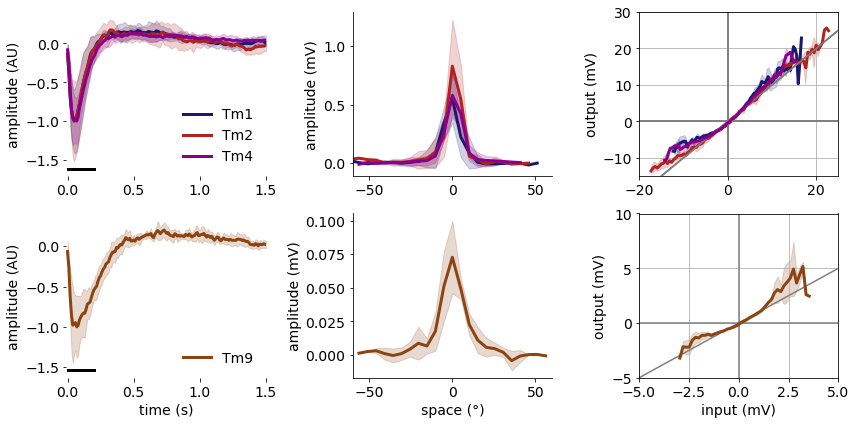

In [8]:
warnings.filterwarnings('ignore')

""" Gridspec """

fig = plt.figure(figsize=(12,6))

#gs = gridspec.GridSpec(2, 3, width_ratios=[3,1,1,3,1,1]) 
gs = fig.add_gridspec(2, 6)
ax00 = fig.add_subplot(gs[0, 0:2])
ax01 = fig.add_subplot(gs[0, 2:4])
ax02 = fig.add_subplot(gs[0, 4:6])

ax10 = fig.add_subplot(gs[1, 0:2])
ax11 = fig.add_subplot(gs[1, 2:4])
ax12 = fig.add_subplot(gs[1, 4:6])



""" Plot temporal filter """


colors = cycle(['midnightblue','firebrick','darkmagenta','saddlebrown'])

for k in ['Tm1-SA','Tm2-SA','Tm4-SA','Tm9-SA']:
    
    d = data[k]['temporal']
    
    t = d['t']
    n = d['n']
    y = d['mean']
    std = d['std']
    std_scale = np.max(np.abs(y))
    data[k]['std_scale'] = std_scale
    std/= std_scale 
    mean_scale = np.max(np.abs(y))
    data[k]['mean_scale'] = mean_scale
    y /= mean_scale

    if (k == 'Tm9-SA'): #or (k == 'Tm4-SA'):
        plt.sca(ax10)
        ax10.set_xlim(-0.01,1.5)
    else:
        plt.sca(ax00)
        ax00.set_xlim(-0.01,1.5)
        
    c = next(colors)
    plt.plot(t,y,label='select '+k+', n='+str(n),color=c,linewidth=3)
    plt.fill_between(t,y-std, y+std, alpha=0.2,color=c)
    print('{}, n={}'.format(k,n))
    

    
""" Plot spatial filter """
for wn in [wn_Tm1_SA,wn_Tm2_SA,wn_Tm4_SA,]:
    plt.sca(ax01)
    fig = plot_spatial_mean(wn,fig=fig,color=next(colors))
for wn in [wn_Tm9_SA]:
    plt.sca(ax11)
    fig = plot_spatial_mean(wn,fig=fig,color=next(colors))
    
    
""" Plot Nonlinearities """
for wn in [wn_Tm1_SA,wn_Tm2_SA,wn_Tm4_SA]:
    plt.sca(ax02)
    fig = plot_nonlin_mean(wn,fig=fig,color=next(colors))
    ax02.set_xlabel('linear input',fontsize=10)
    
for wn in [wn_Tm9_SA]:
    plt.sca(ax12)
    fig = plot_nonlin_mean(wn,fig=fig,color=next(colors))




for a in [ax00,ax01,ax02,ax10,ax11,ax12]:
    a.tick_params(axis='both', which='major', labelsize=font.get_size())
    a.xaxis.get_label().set_fontproperties(font)
    a.yaxis.get_label().set_fontproperties(font)
    
for a in [ax00,ax01,ax10,ax11]:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)


for a in [ax00,ax10]:
    a.spines['bottom'].set_visible(False)
    a.spines['left'].set_visible(False)    
    
    lm = a.get_ylim()
    a.plot([0,0.2],[np.min(lm),np.min(lm)],linewidth=3,color='k')

    
ax02.get_legend().remove()
ax12.get_legend().remove()

for a in [ax00,ax01,ax02]:
    a.set_xlabel('')

ax10.set_xlabel('time (s)')
ax12.set_xlabel('input (mV)')
ax12.set_ylabel('output (mV)')
ax02.set_ylabel('output (mV)')
ax10.set_ylabel('amplitude (AU)')
ax00.set_ylabel('amplitude (AU)')

ax00.legend(['Tm1','Tm2','Tm4'],loc=4,frameon=False,fontsize=font.get_size())
ax10.legend(['Tm9'],loc=4,frameon=False,fontsize=font.get_size())

ax12.set_xlim(-5,5)
ax12.set_ylim(-5,10)

ax02.set_xlim(-20,25)
ax02.set_ylim(-15,30)


plt.tight_layout()
plt.show()


# """ Save figure """
# var = input("Save figures? (y/n): ")
# if var == 'y':
#     fig.savefig(figure_folder+'white-noise-filters.pdf')
#     print('saved figure: ',figure_folder+'white-noise-filters.pdf')

Tm1-SA, n=8
Tm2-SA, n=5
Tm4-SA, n=6
Tm9-SA, n=7


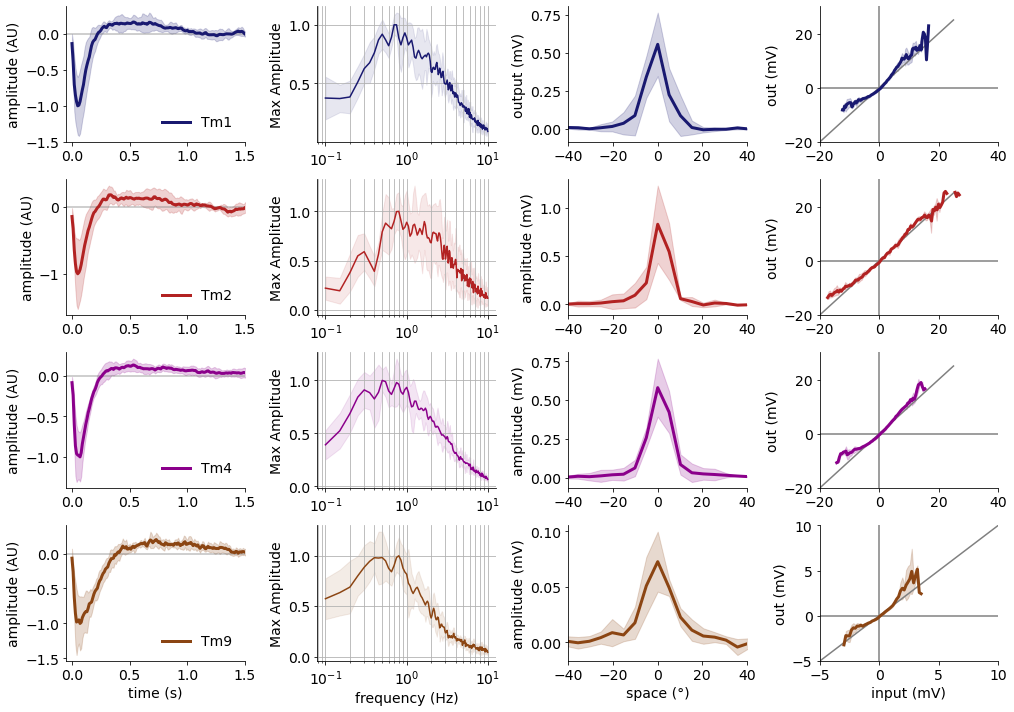

In [9]:
""" Gridspec """

fig = plt.figure(figsize=(14,10))

#gs = gridspec.GridSpec(2, 3, width_ratios=[3,1,1,3,1,1]) 
gs = fig.add_gridspec(4, 4)
ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1])
ax02 = fig.add_subplot(gs[0, 2])
ax03 = fig.add_subplot(gs[0, 3])

ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1])
ax12 = fig.add_subplot(gs[1, 2])
ax13 = fig.add_subplot(gs[1, 3])

ax20 = fig.add_subplot(gs[2, 0])
ax21 = fig.add_subplot(gs[2, 1])
ax22 = fig.add_subplot(gs[2, 2])
ax23 = fig.add_subplot(gs[2, 3])

ax30 = fig.add_subplot(gs[3, 0])
ax31 = fig.add_subplot(gs[3, 1])
ax32 = fig.add_subplot(gs[3, 2])
ax33 = fig.add_subplot(gs[3, 3])



""" Plot temporal filter """


colors_SA = cycle(['midnightblue','firebrick','darkmagenta','saddlebrown'])
for cell,ax in zip(['Tm1','Tm2','Tm4','Tm9'],[ax00,ax10,ax20,ax30]):
    plt.sca(ax)
    
    for k in [cell+'-SA']:

        d = data[k]['temporal']

        t = d['t']
        n = d['n']
        y = d['mean']
        std = d['std']
        std_scale = np.max(np.abs(y))
        data[k]['std_scale'] = std_scale
        std/= std_scale 
        mean_scale = np.max(np.abs(y))
        data[k]['mean_scale'] = mean_scale
        y /= mean_scale

        plt.axhline(0,-0.05,1.5,color='grey',alpha=0.5)
        plt.gca().set_xlim(-0.05,1.5)


        c = next(colors_SA)
        ln = ax.plot(t,y,label='select '+k+', n='+str(n),color=c,linewidth=3)
        ax.fill_between(t,y-std, y+std, alpha=0.2,color=c)
        print('{}, n={}'.format(k,n))
        
    ax.legend(ln,[cell],loc=4,frameon=False,fontsize=font.get_size())
    ax.set_ylabel('amplitude (AU)')
    
    
""" Plot Sine Wave Response """
for wn,ax in zip([wn_Tm1_SA,wn_Tm2_SA,wn_Tm4_SA,wn_Tm9_SA],[ax01,ax11,ax21,ax31]):
    plt.sca(ax)
    fig = plot_sine_response(wn,fig=fig,color=next(colors_SA))

    plt.grid(b=True, which='both')
    ax.set_xscale('log')
    ax.set_ylabel('Max Amplitude')

    
    
""" Plot spatial filter """
for wn,ax in zip([wn_Tm1_SA,wn_Tm2_SA,wn_Tm4_SA,wn_Tm9_SA],[ax02,ax12,ax22,ax32]):
    plt.sca(ax)
    fig = plot_spatial_mean(wn,fig=fig,color=next(colors_SA))
    

    
""" Plot Nonlinearities """
""" Saline """
for wn,ax in zip([wn_Tm1_SA,wn_Tm2_SA,wn_Tm4_SA,wn_Tm9_SA],[ax03,ax13,ax23,ax33]):
    plt.sca(ax)
    fig = plot_nonlin_mean(wn,fig=fig,color=next(colors_SA))
    ax.get_legend().remove()
    ax.set_ylabel('out (mV)')
    #('out (mV)')

    
    
""" Formatting """
import matplotlib.font_manager as fm
font = fm.FontProperties(size=14)

for a in fig.axes:
    a.tick_params(axis='both', which='major', labelsize=font.get_size())
    a.xaxis.get_label().set_fontproperties(font)
    a.yaxis.get_label().set_fontproperties(font)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlabel('')
    
    
for a in [ax03,ax13,ax23,ax33]:

    a.set_xlim(-20,40)
    a.set_ylim(-20,30)
    plt.sca(a)
    plt.grid(b=False, which='both')
    



for a in [ax02,ax12,ax22,ax32]:
    a.set_xlim(-40,40)
    

# Tm9 nonlin lims
ax33.set_xlim(-5,10)
ax33.set_ylim(-5,10)
    


ax30.set_xlabel('time (s)')
ax31.set_xlabel('frequency (Hz)')
ax32.set_xlabel('space (\u00B0)')
ax33.set_xlabel('input (mV)')


ax02.set_ylabel('output (mV)')
ax10.set_ylabel('amplitude (AU)')
ax00.set_ylabel('amplitude (AU)')


plt.tight_layout()
plt.show()

# """ Save figure """
# if save_figures:
#     var = input("Save figures? (y/n): ")
#     if var == 'y':
#         fig.savefig(figure_folder+'white-noise-filters-separate.pdf')
#         print('saved figure: ',figure_folder+'white-noise-filters-separate.pdf')

# Plot Statistics Across Tm1, Tm2, Tm4 and Tm9

Here we plot:
1. The frequency tuning of each cell. Note that Tm9 is tuned to lower frequencies
2. The filter peak times. Note that Tm9 is slower than Tm1, Tm2, and Tm4
3. $R^2$ values for the linear-nonlinear fits (see Methods)

## 1. Baseline (Saline)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


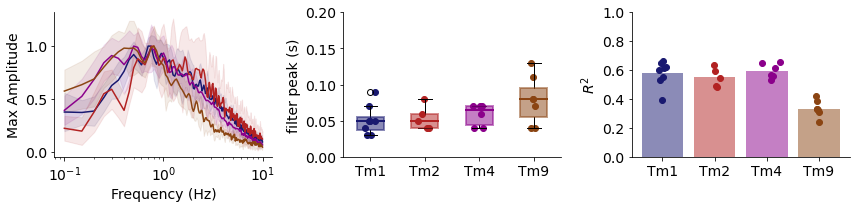

In [10]:
colors = cycle(['midnightblue','firebrick','darkmagenta','saddlebrown'])

fig = plt.figure(figsize=(12,3))

#gs = gridspec.GridSpec(2, 3, width_ratios=[3,1,1,3,1,1]) 
gs = fig.add_gridspec(1, 3)
ax00 = fig.add_subplot(gs[0, 0:1])
ax02 = fig.add_subplot(gs[0, 1:2])
ax01 = fig.add_subplot(gs[0, 2:3]) # flipped these axes


""" Plot Sine Wave Response """
for wn_list in [wn_Tm1_SA,wn_Tm2_SA,wn_Tm4_SA,wn_Tm9_SA]:
    
    plt.sca(ax00)
    fig = plot_sine_response(wn_list,fig=fig,color=next(colors))



""" Plot Individual R2 Values"""
for loc,wn in enumerate([wn_Tm1_SA,wn_Tm2_SA,wn_Tm4_SA,wn_Tm9_SA]):
    plt.sca(ax01)
    fig = plot_r2(wn,loc=loc,fig=fig,color=next(colors))
    
    
""" Plot Individual Peak times """
for loc,wn in enumerate([wn_Tm1_SA,wn_Tm2_SA,wn_Tm4_SA,wn_Tm9_SA]):
    plt.sca(ax02)
    fig = plot_temporal_peak(wn,loc=loc,fig=fig,color=next(colors))


    
    
""" formatting """
ax01.set_xticks([0,1,2,3])
ax01.set_xticklabels(['Tm1','Tm2','Tm4','Tm9'])
ax02.set_xticks([0,1,2,3])
ax02.set_xticklabels(['Tm1','Tm2','Tm4','Tm9'])
ax02.set_ylim(0,0.2)

for a in [ax00,ax01,ax02]:
    a.tick_params(axis='both', which='major', labelsize=font.get_size())
    a.xaxis.get_label().set_fontproperties(font)
    a.yaxis.get_label().set_fontproperties(font)

    
ax00.set_xscale('log')
#ax00.set_yscale('log')
ax00.set_xlabel('Frequency (Hz)')
ax00.set_ylabel('Max Amplitude')
#ax00.legend(['Tm1','Tm2','Tm4','Tm9'],loc=3,frameon=False,fontsize=font.get_size())
ax01.set_ylabel(r'$R^2$')
ax02.set_ylabel('filter peak (s)')

ax01.get_legend().remove()
ax02.get_legend().remove()


for a in [ax00,ax01,ax02]:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# """ Save figure """
# if save_figures:
#     var = input("Save figures? (y/n): ")
#     if var == 'y':
#         fig.savefig(figure_folder+'white-noise-statistics.pdf')
#         print('saved figure: ',figure_folder+'white-noise-statistics.pdf')

## 2. Neuromodulator (Octopamine)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


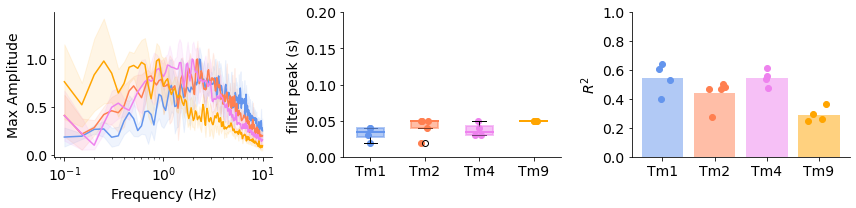

In [11]:

colors = cycle(['cornflowerblue','coral','violet','orange'])

fig = plt.figure(figsize=(12,3))

#gs = gridspec.GridSpec(2, 3, width_ratios=[3,1,1,3,1,1]) 
gs = fig.add_gridspec(1, 3)
ax00 = fig.add_subplot(gs[0, 0:1])
ax02 = fig.add_subplot(gs[0, 1:2])
ax01 = fig.add_subplot(gs[0, 2:3])


""" Plot Sine Wave Response """
for wn_list in [wn_Tm1_OA,wn_Tm2_OA,wn_Tm4_OA,wn_Tm9_OA]:
    
    plt.sca(ax00)
    fig = plot_sine_response(wn_list,fig=fig,color=next(colors))



""" Plot Individual R2 Values"""
for loc,wn in enumerate([wn_Tm1_OA,wn_Tm2_OA,wn_Tm4_OA,wn_Tm9_OA]):
    plt.sca(ax01)
    fig = plot_r2(wn,loc=loc,fig=fig,color=next(colors))
    
    
""" Plot Individual Peak times """
for loc,wn in enumerate([wn_Tm1_OA,wn_Tm2_OA,wn_Tm4_OA,wn_Tm9_OA]):
    plt.sca(ax02)
    fig = plot_temporal_peak(wn,loc=loc,fig=fig,color=next(colors))


    
    
""" formatting """
ax01.set_xticks([0,1,2,3])
ax01.set_xticklabels(['Tm1','Tm2','Tm4','Tm9'])
ax02.set_xticks([0,1,2,3])
ax02.set_xticklabels(['Tm1','Tm2','Tm4','Tm9'])
ax02.set_ylim(0,0.2)

for a in [ax00,ax01,ax02]:
    a.tick_params(axis='both', which='major', labelsize=font.get_size())
    a.xaxis.get_label().set_fontproperties(font)
    a.yaxis.get_label().set_fontproperties(font)

    
ax00.set_xscale('log')
#ax00.set_yscale('log')
ax00.set_xlabel('Frequency (Hz)')
ax00.set_ylabel('Max Amplitude')
#ax00.legend(['Tm1','Tm2','Tm4','Tm9'],loc=3,frameon=False,fontsize=font.get_size())
ax01.set_ylabel(r'$R^2$')
ax02.set_ylabel('filter peak (s)')

ax01.get_legend().remove()
ax02.get_legend().remove()


for a in [ax00,ax01,ax02]:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# """ Save figure """
# if save_figures:
#     var = input("Save figures? (y/n): ")
#     if var == 'y':
#         fig.savefig(figure_folder+'white-noise-statistics-OA.pdf')
#         print('saved figure: ',figure_folder+'white-noise-statistics-OA.pdf')

# Plot for White Noise filters for both saline and OA

This is the same format as above, with the OA traces superimposed

Tm1-SA, n=8
Tm1-OA, n=4
Tm2-SA, n=5
Tm2-OA, n=5
Tm4-SA, n=6
Tm4-OA, n=4
Tm9-SA, n=7
Tm9-OA, n=4


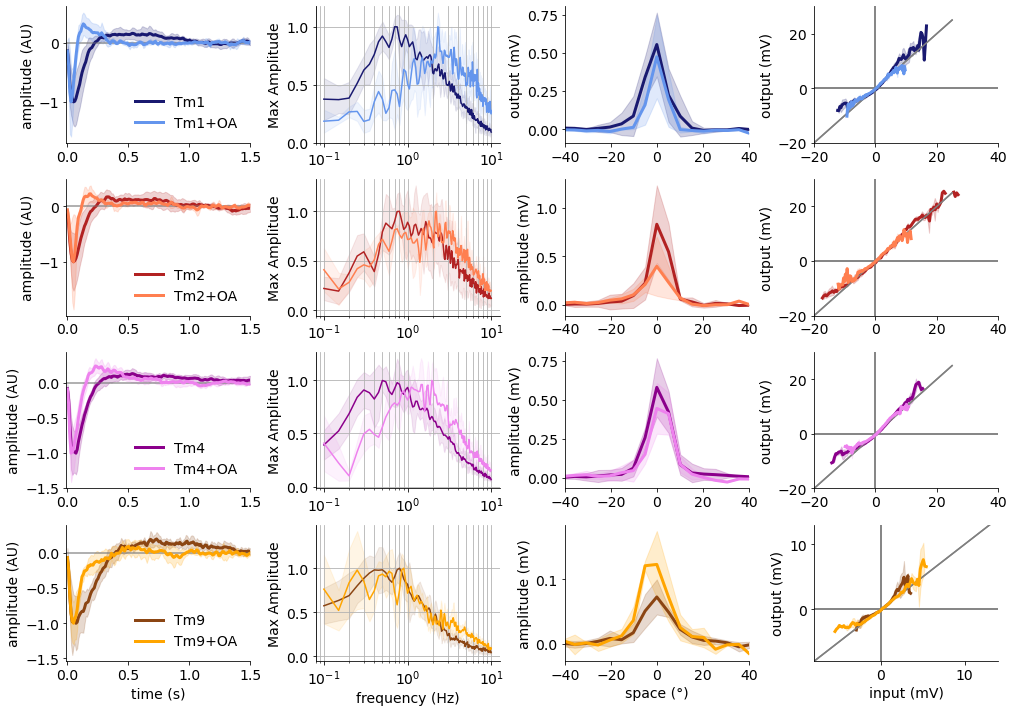

In [12]:
""" Gridspec """

fig = plt.figure(figsize=(14,10))

#gs = gridspec.GridSpec(2, 3, width_ratios=[3,1,1,3,1,1]) 
gs = fig.add_gridspec(4, 4)
ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1])
ax02 = fig.add_subplot(gs[0, 2])
ax03 = fig.add_subplot(gs[0, 3])

ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1])
ax12 = fig.add_subplot(gs[1, 2])
ax13 = fig.add_subplot(gs[1, 3])

# 0:2])
# 2:3])
# 3:4])
# 4:5])

ax20 = fig.add_subplot(gs[2, 0])
ax21 = fig.add_subplot(gs[2, 1])
ax22 = fig.add_subplot(gs[2, 2])
ax23 = fig.add_subplot(gs[2, 3])

ax30 = fig.add_subplot(gs[3, 0])
ax31 = fig.add_subplot(gs[3, 1])
ax32 = fig.add_subplot(gs[3, 2])
ax33 = fig.add_subplot(gs[3, 3])



""" Plot temporal filter """


colors = cycle(['midnightblue','cornflowerblue','firebrick','coral','darkmagenta','violet','saddlebrown','orange'])
colors_SA = cycle(['midnightblue','firebrick','darkmagenta','saddlebrown'])
colors_OA = cycle(['cornflowerblue','coral','violet','orange'])
for cell,ax in zip(['Tm1','Tm2','Tm4','Tm9'],[ax00,ax10,ax20,ax30]):
    plt.sca(ax)
    
    line_handles = []
    for k in [cell+'-SA',cell+'-OA']:

        d = data[k]['temporal']

        t = d['t']
        n = d['n']
        y = d['mean']
        std = d['std']
        std_scale = np.max(np.abs(y))
        data[k]['std_scale'] = std_scale
        std/= std_scale 
        mean_scale = np.max(np.abs(y))
        data[k]['mean_scale'] = mean_scale
        y /= mean_scale

        plt.axhline(0,-0.05,1.5,color='grey',alpha=0.5)
        plt.gca().set_xlim(-0.01,1.5)


        c = next(colors)
        ln = ax.plot(t,y,label='select '+k+', n='+str(n),color=c,linewidth=3)
        ax.fill_between(t,y-std, y+std, alpha=0.2,color=c)
        print('{}, n={}'.format(k,n))
        line_handles.append(ln[0])
        
    ax.legend(line_handles[:2],[cell,cell+'+OA'],loc=4,frameon=False,fontsize=font.get_size())
    ax.set_ylabel('amplitude (AU)')
    
    
""" Plot Sine Wave Response """
for wn,ax in zip([wn_Tm1_SA,wn_Tm2_SA,wn_Tm4_SA,wn_Tm9_SA],[ax01,ax11,ax21,ax31]):
    plt.sca(ax)
    
    fig = plot_sine_response(wn,fig=fig,color=next(colors_SA),baseline=None)

    
for wn,ax in zip([wn_Tm1_OA,wn_Tm2_OA,wn_Tm4_OA,wn_Tm9_OA],[ax01,ax11,ax21,ax31]):
    plt.sca(ax)

    fig = plot_sine_response(wn,fig=fig,color=next(colors_OA),baseline=None)
    plt.grid(b=True, which='both')
    ax.set_xscale('log')
    ax.set_ylabel('Max Amplitude')
    
    
    
""" Plot spatial filter """
for wn,ax in zip([wn_Tm1_SA,wn_Tm2_SA,wn_Tm4_SA,wn_Tm9_SA],[ax02,ax12,ax22,ax32]):
    plt.sca(ax)
    fig = plot_spatial_mean(wn,fig=fig,color=next(colors_SA))
    
for wn,ax in zip([wn_Tm1_OA,wn_Tm2_OA,wn_Tm4_OA,wn_Tm9_OA],[ax02,ax12,ax22,ax32]):
    plt.sca(ax)
    fig = plot_spatial_mean(wn,fig=fig,color=next(colors_OA))

    
""" Plot Nonlinearities """
""" Saline """
for wn,ax in zip([wn_Tm1_SA,wn_Tm2_SA,wn_Tm4_SA,wn_Tm9_SA],[ax03,ax13,ax23,ax33]):
    plt.sca(ax)
    fig = plot_nonlin_mean(wn,fig=fig,color=next(colors_SA))
    ax.get_legend().remove()
""" Octopamine """
for wn,ax in zip([wn_Tm1_OA,wn_Tm2_OA,wn_Tm4_OA,wn_Tm9_OA],[ax03,ax13,ax23,ax33]):
    plt.sca(ax)
    fig = plot_nonlin_mean(wn,fig=fig,color=next(colors_OA))
    ax.get_legend().remove()
    ax.set_ylabel('output (mV)',fontsize=font.get_size())
    
    
    
""" Formatting """
import matplotlib.font_manager as fm
font = fm.FontProperties(size=14)

for a in fig.axes:
    a.tick_params(axis='both', which='major', labelsize=font.get_size())
    a.xaxis.get_label().set_fontproperties(font)
    a.yaxis.get_label().set_fontproperties(font)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlabel('')
    
for a in [ax03,ax13,ax23,ax33]:
    #a.spines['top'].set_visible(True)
    #a.spines['right'].set_visible(True)

    a.set_xlim(-20,40)
    a.set_ylim(-20,30)

for a in [ax02,ax12,ax22,ax32]:
    a.set_xlim(-40,40)
    

# Tm9 nonlin lims
ax33.set_xlim(-8,14)
ax33.set_ylim(-8,13)
    

ax30.set_xlabel('time (s)')
ax31.set_xlabel('frequency (Hz)')
ax32.set_xlabel('space (\u00B0)')
ax33.set_xlabel('input (mV)')


ax02.set_ylabel('output (mV)')
ax10.set_ylabel('amplitude (AU)')
ax00.set_ylabel('amplitude (AU)')

plt.tight_layout()
plt.show()

# if save_figures:
#     """ Save figure """
#     var = input("Save figures? (y/n): ")
#     if var == 'y':
#         fig.savefig(figure_folder+'white-noise-filters-OA.pdf')
#         print('saved figure: ',figure_folder+'white-noise-filters-OA.pdf')

# Plot Drifting Grating Responses

We showed drifting grating stimuli moving at 0.5 Hz with varying spatial frequencies (x-axis). This classic paradigm is used in visual neuroscience to find evidence for "spatial surrounds" in the receptive fields of 

Note that the following plots were not included in the publication. However, the drifting grating data was used for analysis in supplementary Figure S6

Some interesting things to note:

* Tm1 (blue) and Tm4 (purple) seem to peak around 20-40 degrees; the fact that they decrease in amplitude indicates the presence of a small spatial surround. We explored the effects of this with our modeling (not published), and did not find a difference from our main computational result (Figures 5,6). We therefore, for simplicity, excluded this from the paper.
* For most cells, there does not seem to be a difference between the baseline (saline) condition and the octopamine condition

In [13]:
import pickle

# Tm1
with open('../data/KohnPortes2021/dg_Tm1_SA.pickle', 'rb') as handle:
    dg_Tm1_SA = pickle.load(handle)
with open('../data/KohnPortes2021/dg_Tm1_OA.pickle', 'rb') as handle:
    dg_Tm1_OA = pickle.load(handle)

# Tm2
with open('../data/KohnPortes2021/dg_Tm2_SA.pickle', 'rb') as handle:
    dg_Tm2_SA = pickle.load(handle)
with open('../data/KohnPortes2021/dg_Tm2_OA.pickle', 'rb') as handle:
    dg_Tm2_OA = pickle.load(handle)

# Tm4
with open('../data/KohnPortes2021/dg_Tm4_SA.pickle', 'rb') as handle:
    dg_Tm4_SA = pickle.load(handle)
with open('../data/KohnPortes2021/dg_Tm4_OA.pickle', 'rb') as handle:
    dg_Tm4_OA = pickle.load(handle)

# Tm9
with open('../data/KohnPortes2021/dg_Tm9_SA.pickle', 'rb') as handle:
    dg_Tm9_SA = pickle.load(handle)
with open('../data/KohnPortes2021/dg_Tm9_OA.pickle', 'rb') as handle:
    dg_Tm9_OA = pickle.load(handle)

## Saline vs. OA

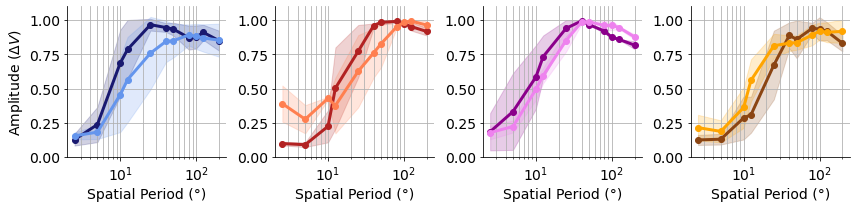

In [14]:
"""Plot Drifting Grating"""


normalize = True # normalize each cell before averaging

fig = plt.figure(figsize=(12,3))

#gs = gridspec.GridSpec(2, 3, width_ratios=[3,1,1,3,1,1]) 
gs = fig.add_gridspec(1, 4)
ax00 = fig.add_subplot(gs[0,0:1])
ax10 = fig.add_subplot(gs[0,1:2])
ax20 = fig.add_subplot(gs[0,2:3])
ax30 = fig.add_subplot(gs[0,3:4])

# save figures:
var = 'n'

c = ['midnightblue','cornflowerblue','firebrick','coral','darkmagenta','violet','saddlebrown','orange']
fig.sca(ax00)
fig = plot_dg_peaks_mean(dg_Tm1_SA,normalize=normalize,color=c[0],fig=fig)
fig.gca().set_ylim(top=0.045)

fig = plot_dg_peaks_mean(dg_Tm1_OA,normalize=normalize,fig=fig,color=c[1])
fig.gca().set_ylim(top=0.045)
legend = fig.gca().legend()
legend.remove()

if var == 'y': fig.savefig(filedir+'Tm1-dg'+'.pdf')


""" Tm2 """
fig.sca(ax10)
fig = plot_dg_peaks_mean(dg_Tm2_SA,normalize=normalize,color=c[2],fig=fig)

fig = plot_dg_peaks_mean(dg_Tm2_OA,normalize=normalize,fig=fig,color=c[3])
fig.gca().set_ylim(top=0.045)
legend = fig.gca().legend()
legend.remove()

""" Tm4 """
fig.sca(ax20)
fig = plot_dg_peaks_mean(dg_Tm4_SA,normalize=normalize,color=c[4],fig=fig)

fig = plot_dg_peaks_mean(dg_Tm4_OA,normalize=normalize,fig=fig,color=c[5])
fig.gca().set_ylim(top=0.045)
legend = fig.gca().legend()
legend.remove()




""" Tm9 """
fig.sca(ax30)
fig = plot_dg_peaks_mean(dg_Tm9_SA,normalize=normalize,color=c[6],fig=fig)


fig = plot_dg_peaks_mean(dg_Tm9_OA,normalize=normalize,fig=fig,color=c[7])


font = fm.FontProperties(size=14)

for a in fig.axes:
    if normalize:
        a.set_ylim(top=1.1) #
        
    else:
        a.set_ylim(top=0.045)
        
    a.tick_params(axis='both', which='both', labelsize=font.get_size())
    a.xaxis.get_label().set_fontproperties(font)
    a.yaxis.get_label().set_fontproperties(font)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    if a != ax00:
        a.set_ylabel('')

    a.set_xlabel('Spatial Period (\u00b0)')
    
    a.legend().remove()
    

plt.tight_layout()

# """ Save figure """
# if save_figures:
#     var = input("Save figures? (y/n): ")
#     if var == 'y':
#         fig.savefig(figure_folder+'drifting-grating-OA.pdf')
#         print('saved figure: ',figure_folder+'drifting-grating-OA.pdf')


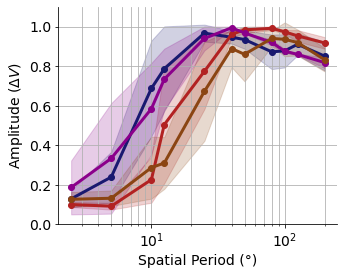

In [15]:
normalize=True

fig,ax = plt.subplots(1,1,figsize=(5,4))
fig = plot_dg_peaks_mean(dg_Tm1_SA,normalize=normalize,color=c[0],fig=fig)
#fig.gca().set_title('Drifting Grating Tm1 saline')
fig.gca().set_ylim(top=0.045)
#fig.show()

fig = plot_dg_peaks_mean(dg_Tm2_SA,normalize=normalize,fig=fig,color=c[2])
fig.gca().set_ylim(top=0.045)
legend = fig.gca().legend()
legend.remove()

fig = plot_dg_peaks_mean(dg_Tm4_SA,normalize=normalize,fig=fig,color=c[4])
#fig.gca().set_title('Drifting Grating Tm1 OA')
fig.gca().set_ylim(top=0.045)
legend = fig.gca().legend()
legend.remove()

fig = plot_dg_peaks_mean(dg_Tm9_SA,normalize=normalize,fig=fig,color=c[6])
#fig.gca().set_title('Drifting Grating Tm1 OA')

if normalize:
    fig.gca().set_ylim(top=1.1)
else:
    fig.gca().set_ylim(top=0.045)
    
    
for a in fig.axes:
    if normalize:
        a.set_ylim(top=1.1) #
        
    else:
        a.set_ylim(top=0.045)
    
    #a.set_xscale('linear')
    
    a.tick_params(axis='both', which='both', labelsize=font.get_size())
    a.xaxis.get_label().set_fontproperties(font)
    a.yaxis.get_label().set_fontproperties(font)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlabel('Spatial Period (\u00b0)')
    
    a.legend().remove()
#fig.gca().set_xscale('linear')
legend = fig.gca().legend()
legend.remove()

# """ Save figure """
# if save_figures:
#     var = input("Save figures? (y/n): ")
#     if var == 'y':
#         fig.savefig(figure_folder+'drifting-grating-all.pdf')
#         print('saved figure: ',figure_folder+'drifting-grating-all.pdf')
